In [1]:
import os

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
ds = xr.open_dataset('/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/power_nasa_data.nc')

In [3]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:            (time: 25491, lat: 45, lon: 36)
Coordinates:
  * time               (time) datetime64[ns] 204kB 2001-01-01 ... 2024-04-06
  * lat                (lat) float64 360B -4.5 -4.0 -3.5 -3.0 ... 16.5 17.0 17.5
  * lon                (lon) float64 288B 29.38 30.0 30.62 ... 50.0 50.62 51.25
Data variables: (12/15)
    PRECTOTCORR        (time, lat, lon) float64 330MB ...
    EVPTRNS            (time, lat, lon) float64 330MB ...
    T2M                (time, lat, lon) float64 330MB ...
    TS                 (time, lat, lon) float64 330MB ...
    PS                 (time, lat, lon) float64 330MB ...
    WS2M               (time, lat, lon) float64 330MB ...
    ...                 ...
    GWETROOT           (time, lat, lon) float64 330MB ...
    GWETPROF           (time, lat, lon) float64 330MB ...
    GWETTOP            (time, lat, lon) float64 330MB ...
    PRECIPITATIONCAL   (time, lat, lon) float64 330MB ...
    CLOUD_AMT          (time, lat, lon) float64 330MB ...
    ALLSKY_SFC_SW_DWN  (time, lat, lon) float64 330MB ...

In [4]:
def count_missing_values_table(ds, missing_value_indicator=999.0):
    """
    Counts missing values in each data variable within an xarray Dataset and returns the results in a DataFrame.
    Missing values are identified as either NaN or a specified missing value indicator (e.g., 999.0).

    Parameters:
    - ds (xarray.Dataset): The dataset to analyze.
    - missing_value_indicator (float, optional): The numerical value used to indicate missing data. Defaults to 999.0.

    Returns:
    - pd.DataFrame: A DataFrame where columns are 'Variable', 'NaN Count', 'Custom Missing Count', and 'Total Missing'.
    """
    missing_values = []
    for var in ds.data_vars:
        # Counting NaN values
        nan_count = ds[var].isnull().sum().item()
        # Counting values equal to the specified missing value indicator
        custom_missing_count = (ds[var] == missing_value_indicator).sum().item()
        # Summing both counts to get the total number of missing values
        total_missing = nan_count + custom_missing_count
        missing_values.append({'Variable': var, 'NaN Count': nan_count, 'Custom Missing Count': custom_missing_count, 'Total Missing': total_missing})

    # Convert list of dictionaries to DataFrame
    missing_values_df = pd.DataFrame(missing_values)
    return missing_values_df

In [5]:
missing_values_df = count_missing_values_table(ds)
missing_values_df

,Variable,NaN Count,Custom Missing Count,Total Missing
0,PRECTOTCORR,35109604,0,35109604
1,EVPTRNS,35213096,0,35213096
2,T2M,35109604,0,35109604
3,TS,35109604,0,35109604
4,PS,35109604,0,35109604
5,WS2M,35109604,0,35109604
6,WS10M,35109604,0,35109604
7,QV2M,35109604,0,35109604
8,RH2M,35109604,0,35109604
9,GWETROOT,35213096,0,35213096


latency in CERES they providing data with 3-4 months delay, last date 2023-11-30, information from POWER NASA team

In [6]:
import pandas as pd
import xarray as xr

def drop_rows_after_date(ds, cutoff_date):
    """
    Drops rows from an xarray Dataset after a specified cutoff date, accounting for non-unique time values due to different regions.

    Parameters:
    - ds (xarray.Dataset): The input dataset containing time-series data across different spatial coordinates.
    - cutoff_date (str): The cutoff date in 'YYYY-MM-DD' format. Rows after this date will be dropped, across all regions.

    Returns:
    - xarray.Dataset: The dataset with rows after the cutoff date removed, preserving data across all spatial dimensions.

    Example of usage:
    ds_filtered = drop_rows_after_date(ds, '2023-11-30')

    Author:
    - Adam Przychodni
    """
    # Convert the cutoff_date string to a pandas datetime object
    cutoff_datetime = pd.to_datetime(cutoff_date)
    
    # Filter the dataset where the time is less than or equal to the cutoff date
    filtered_ds = ds.sel(time=ds.time <= cutoff_datetime)
    
    return filtered_ds

# Example of usage
# Assuming 'ds' is your dataset loaded with xarray.open_dataset('filename.nc')
ds_filtered = drop_rows_after_date(ds, '2023-11-30')


In [7]:
ds_filtered

<xarray.Dataset> Size: 5GB
Dimensions:            (time: 25107, lat: 45, lon: 36)
Coordinates:
  * time               (time) datetime64[ns] 201kB 2001-01-01 ... 2023-11-30
  * lat                (lat) float64 360B -4.5 -4.0 -3.5 -3.0 ... 16.5 17.0 17.5
  * lon                (lon) float64 288B 29.38 30.0 30.62 ... 50.0 50.62 51.25
Data variables: (12/15)
    PRECTOTCORR        (time, lat, lon) float64 325MB nan nan nan ... nan nan
    EVPTRNS            (time, lat, lon) float64 325MB nan nan nan ... nan nan
    T2M                (time, lat, lon) float64 325MB nan nan nan ... nan nan
    TS                 (time, lat, lon) float64 325MB nan nan nan ... nan nan
    PS                 (time, lat, lon) float64 325MB nan nan nan ... nan nan
    WS2M               (time, lat, lon) float64 325MB nan nan nan ... nan nan
    ...                 ...
    GWETROOT           (time, lat, lon) float64 325MB nan nan nan ... nan nan
    GWETPROF           (time, lat, lon) float64 325MB nan nan nan ... nan nan
    GWETTOP            (time, lat, lon) float64 325MB nan nan nan ... nan nan
    PRECIPITATIONCAL   (time, lat, lon) float64 325MB nan nan nan ... nan nan
    CLOUD_AMT          (time, lat, lon) float64 325MB nan nan nan ... nan nan
    ALLSKY_SFC_SW_DWN  (time, lat, lon) float64 325MB nan nan nan ... nan nan

In [8]:
missing_values_df = count_missing_values_table(ds_filtered)
missing_values_df

,Variable,NaN Count,Custom Missing Count,Total Missing
0,PRECTOTCORR,34580708,0,34580708
1,EVPTRNS,34614184,0,34614184
2,T2M,34580708,0,34580708
3,TS,34580708,0,34580708
4,PS,34580708,0,34580708
5,WS2M,34580708,0,34580708
6,WS10M,34580708,0,34580708
7,QV2M,34580708,0,34580708
8,RH2M,34580708,0,34580708
9,GWETROOT,34614184,0,34614184


In [9]:
import xarray as xr

# Assuming ds is your loaded xarray.Dataset
# Check for missing values in each variable for each time point
missing_values_per_day = ds_filtered.isnull().any(dim=('lat', 'lon'))

# This creates a new dataset where each data variable indicates whether there were any missing values
# at each time point across lat and lon dimensions

# Now check if any of the data variables has missing values for each time point
days_with_missing_data = missing_values_per_day.to_array().any('variable')

# Extract times where there are any missing data
times_with_missing_data = days_with_missing_data.where(days_with_missing_data, drop=True).time

# Print out the times with missing data
times_with_missing_data


<xarray.DataArray 'time' (time: 25107)> Size: 201kB
array(['2001-01-01T00:00:00.000000000', '2001-01-02T00:00:00.000000000',
       '2001-01-03T00:00:00.000000000', ..., '2023-11-28T00:00:00.000000000',
       '2023-11-29T00:00:00.000000000', '2023-11-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 201kB 2001-01-01 2001-01-02 ... 2023-11-30

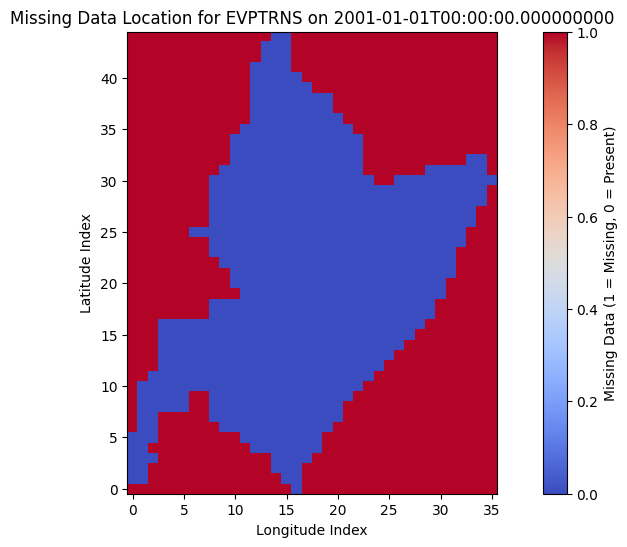

In [10]:
import xarray as xr
import matplotlib.pyplot as plt

# Load your dataset
# ds = xr.open_dataset('your_dataset.nc')

# Select the variable and check for NaNs
variable_name = 'EVPTRNS'  # Change this to your variable of interest
data_var = ds_filtered[variable_name].isel(time=0)  # Change index for different days

# Create a boolean mask where True indicates missing values
missing_mask = data_var.isnull()

# Plot the results
plt.figure(figsize=(12, 6))
plt.imshow(missing_mask, origin='lower', cmap='coolwarm', interpolation='none')
plt.colorbar(label='Missing Data (1 = Missing, 0 = Present)')
plt.title(f'Missing Data Location for {variable_name} on {data_var.time.values}')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()


In [11]:
import xarray as xr

# Assume ds is your xarray.Dataset already loaded
# Iterate over each data variable, apply the notnull mask, and aggregate it
cleaned_vars = {}

for var_name in ds_filtered.data_vars:
    # Create a mask that is True where the data is not NaN
    not_null_mask = ds_filtered[var_name].notnull()

    # Ensure that the condition holds true across all dimensions for each data point,
    # including the 'time' dimension
    not_null_mask = not_null_mask.all(dim=('time', 'lat', 'lon'))

    # Apply the mask to the data variable, dropping the NaNs
    cleaned_var = ds_filtered[var_name].where(not_null_mask, drop=True)
    
    # Store the cleaned data in a dictionary
    cleaned_vars[var_name] = cleaned_var

# Reassemble the cleaned variables into a new dataset
cleaned_ds = xr.Dataset(cleaned_vars)

# Print the structure of the new dataset
cleaned_ds


<xarray.Dataset> Size: 5GB
Dimensions:            (time: 25107, lat: 45, lon: 36)
Coordinates:
  * time               (time) datetime64[ns] 201kB 2001-01-01 ... 2023-11-30
  * lat                (lat) float64 360B -4.5 -4.0 -3.5 -3.0 ... 16.5 17.0 17.5
  * lon                (lon) float64 288B 29.38 30.0 30.62 ... 50.0 50.62 51.25
Data variables: (12/15)
    PRECTOTCORR        (time, lat, lon) float64 325MB nan nan nan ... nan nan
    EVPTRNS            (time, lat, lon) float64 325MB nan nan nan ... nan nan
    T2M                (time, lat, lon) float64 325MB nan nan nan ... nan nan
    TS                 (time, lat, lon) float64 325MB nan nan nan ... nan nan
    PS                 (time, lat, lon) float64 325MB nan nan nan ... nan nan
    WS2M               (time, lat, lon) float64 325MB nan nan nan ... nan nan
    ...                 ...
    GWETROOT           (time, lat, lon) float64 325MB nan nan nan ... nan nan
    GWETPROF           (time, lat, lon) float64 325MB nan nan nan ... nan nan
    GWETTOP            (time, lat, lon) float64 325MB nan nan nan ... nan nan
    PRECIPITATIONCAL   (time, lat, lon) float64 325MB nan nan nan ... nan nan
    CLOUD_AMT          (time, lat, lon) float64 325MB nan nan nan ... nan nan
    ALLSKY_SFC_SW_DWN  (time, lat, lon) float64 325MB nan nan nan ... nan nan

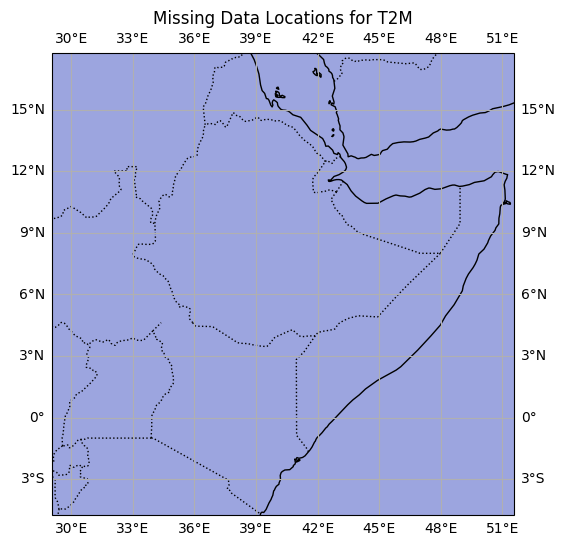

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_missing_data(ds, variable_name):
    """
    Plots a map showing areas with missing data for a specific variable in an xarray Dataset.

    Parameters:
    - ds (xarray.Dataset): The dataset.
    - variable_name (str): The name of the variable to check for missing data.
    """
    # Load the data variable
    data = ds[variable_name]
    
    # Create a mask where data is NaN
    missing_mask = np.isnan(data.mean(dim='time'))  # Taking mean over time if the data is time-resolved

    # Setup the plot with geographic projections
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()

    # Plot the missing data locations
    ax.pcolormesh(ds.lon, ds.lat, missing_mask, transform=ccrs.PlateCarree(), cmap='coolwarm', alpha=0.5)

    # Add features and gridlines
    ax.add_feature(cfeature.BORDERS, linestyle=':')  # Corrected reference here
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Show the plot
    plt.title(f'Missing Data Locations for {variable_name}')
    plt.show()

# Assuming ds is your loaded dataset
plot_missing_data(cleaned_ds, 'T2M')


In [25]:
missing_values_df = count_missing_values_table(cleaned_ds)
missing_values_df

,Variable,NaN Count,Custom Missing Count,Total Missing
0,PRECTOTCORR,40673340,0,40673340
1,EVPTRNS,40673340,0,40673340
2,T2M,40673340,0,40673340
3,TS,40673340,0,40673340
4,PS,40673340,0,40673340
5,WS2M,40673340,0,40673340
6,WS10M,40673340,0,40673340
7,QV2M,40673340,0,40673340
8,RH2M,40673340,0,40673340
9,GWETROOT,40673340,0,40673340


In [14]:
def drop_variables(ds, variables_to_drop):
    """
    Drops specified variables from an xarray Dataset.

    Parameters:
    - ds (xarray.Dataset): The input dataset from which variables will be dropped.
    - variables_to_drop (list of str): A list of strings representing the variable names to be dropped.

    Returns:
    - xarray.Dataset: The dataset with specified variables removed.

    Example of usage:
    variables_to_drop = ['PRECIPITATIONCAL', 'AIRMASS']
    ds_cleaned = drop_variables(ds, variables_to_drop)

    Author:
    - Adam Przychodni
    """
    # Use the .drop_vars method to remove specified variables
    cleaned_ds = ds.drop_vars(variables_to_drop)
    
    return cleaned_ds

# Example of usage
# Assuming 'ds' is your dataset loaded with xarray.open_dataset('power_nasa_data.nc')
# variables_to_drop = ['PRECIPITATIONCAL', 'AIRMASS']
# ds_cleaned = drop_variables(ds_filtered, variables_to_drop)

In [15]:
def count_missing_values_for_whole_ds(ds):
    """
    Counts the total number of missing values across all variables in an xarray Dataset.

    Parameters:
    - ds (xarray.Dataset): The input dataset.

    Returns:
    - int: The total number of missing values across all variables in the dataset.

    Example of usage:
    total_missing_values = count_missing_values(ds_cleaned)

    Author:
    - Adam Przychodni
    """
    # Use the isnull method to identify missing values, then sum them up
    missing_values_count = ds.isnull().sum().to_array().sum().item()
    
    return missing_values_count

In [16]:
ds_filtered

<xarray.Dataset> Size: 5GB
Dimensions:            (time: 25107, lat: 45, lon: 36)
Coordinates:
  * time               (time) datetime64[ns] 201kB 2001-01-01 ... 2023-11-30
  * lat                (lat) float64 360B -4.5 -4.0 -3.5 -3.0 ... 16.5 17.0 17.5
  * lon                (lon) float64 288B 29.38 30.0 30.62 ... 50.0 50.62 51.25
Data variables: (12/15)
    PRECTOTCORR        (time, lat, lon) float64 325MB nan nan nan ... nan nan
    EVPTRNS            (time, lat, lon) float64 325MB nan nan nan ... nan nan
    T2M                (time, lat, lon) float64 325MB nan nan nan ... nan nan
    TS                 (time, lat, lon) float64 325MB nan nan nan ... nan nan
    PS                 (time, lat, lon) float64 325MB nan nan nan ... nan nan
    WS2M               (time, lat, lon) float64 325MB nan nan nan ... nan nan
    ...                 ...
    GWETROOT           (time, lat, lon) float64 325MB nan nan nan ... nan nan
    GWETPROF           (time, lat, lon) float64 325MB nan nan nan ... nan nan
    GWETTOP            (time, lat, lon) float64 325MB nan nan nan ... nan nan
    PRECIPITATIONCAL   (time, lat, lon) float64 325MB nan nan nan ... nan nan
    CLOUD_AMT          (time, lat, lon) float64 325MB nan nan nan ... nan nan
    ALLSKY_SFC_SW_DWN  (time, lat, lon) float64 325MB nan nan nan ... nan nan

In [26]:
# Example of usage
# Assuming 'ds_cleaned' is your dataset after variables have been dropped
total_missing_values = count_missing_values_for_whole_ds(cleaned_ds)
print(f"Total missing values in the dataset: {total_missing_values}")

Total missing values in the dataset: 610100100


In [18]:
# ADDING ITEM_ID FOR AUTOGLUON POSSIBLY

# import numpy as np

# # Assuming ds_cleaned is your xarray.Dataset
# latitudes = ds_cleaned.lat.values
# longitudes = ds_cleaned.lon.values

# # Calculate the total number of latitudes and longitudes
# n_lat = len(latitudes)
# n_lon = len(longitudes)

# # Create an array of integers representing each unique lat-lon pair
# # This essentially numbers each grid point based on its position
# item_ids = np.arange(n_lat * n_lon).reshape(n_lat, n_lon)

# # Convert the array of item_ids into a DataArray, with the same lat and lon dimensions
# item_id_da = xr.DataArray(item_ids, coords=[("lat", latitudes), ("lon", longitudes)])

# # Adding the item_id DataArray to the dataset
# ds_cleaned['item_id'] = item_id_da


# Experiment 0.01
## Potential Target Variables:
In Ethiopia, where agriculture heavily relies on precise water management, accurately predicting soil wetness at different depths—GWETROOT, GWETPROF, and GWETTOP—is crucial. These variables provide essential data on surface and sub-surface moisture levels, enabling optimal decision-making for crop planting, irrigation scheduling, and drought management. Currently, these are experimental metrics; we will determine which variable is most effective for our applications through ongoing research and testing.

## Features:
### Hydrological Inputs and Outputs
- Precipitation (PRECTOTCORR): The primary source of water for soil in Botswana and Zimbabwe, essential for replenishing soil moisture. Precipitation directly increases GWETROOT, making it a pivotal variable for predicting changes in soil moisture levels.

- Evapotranspiration (EVPTRNS): Represents water loss from the soil through evaporation and from plants through transpiration. It's a significant factor in soil moisture depletion, especially during warm and sunny conditions typical of these regions. Modeling evapotranspiration aids in understanding the outflow of water from the soil system, balancing the input from precipitation.

### Climatic and Atmospheric Conditions
- Air Temperature (T2M) and Surface Temperature (TS): Both influence the rate of evaporation and plant transpiration. Higher temperatures can lead to increased evaporation rates, thereby reducing GWETROOT. They are indicators of the energy available for water to transition from liquid to vapor.

- Solar Radiation (ALLSKY_SFC_SW_DWN): Drives evaporation by providing the necessary energy. It directly impacts how quickly soil moisture can decrease under sunny conditions versus how it might be conserved on cloudier days.

- Cloud Cover (CLOUD_AMT): Influences the amount of solar radiation that reaches the surface, thus affecting evaporation rates. Additionally, cloud cover is often associated with precipitation events, providing indirect clues about potential increases in soil moisture.

- Surface Pressure (PS): Changes in surface pressure can indicate incoming weather systems that might alter precipitation patterns, temperature, and cloud cover, thereby affecting soil moisture levels indirectly.

### Wind and Humidity Dynamics
- Wind Speed at 2 Meters (WS2M) and Wind Speed at 10 Meters (WS10M): Wind enhances evaporation by moving moist air away from the soil surface and facilitating the arrival of drier air. This process can significantly impact the rate at which soil moisture is lost to the atmosphere.

- Specific Humidity at 2 Meters (QV2M): Higher humidity levels can reduce the gradient between the moisture in the soil and the air, potentially lowering the rate of evaporation. This variable helps in understanding the atmospheric demand for moisture from the soil.

- Relative Humidity at 2 Meters (RH2M): Offers insights into the moisture content of the air near the soil surface. Low relative humidity indicates a higher potential for evaporation, leading to faster depletion of soil moisture.

### Enhanced Solar Radiation Measurement
- All Sky Surface Shortwave Downward Irradiance (ALLSKY_SFC_SW_DWN): Provides a detailed measure of solar energy reaching the ground, factoring in cloud cover and atmospheric conditions. This nuanced view helps in estimating the potential for soil warming and drying, crucial for predicting changes in GWETROOT.

## Summary of the selection:

Direct Influences: Precipitation (PRECTOTCORR) and Evapotranspiration (EVPTRNS) represent the most direct inputs and outputs of water in the soil system, crucial for any soil moisture model.

Climatic Factors: Temperature (T2M, TS), Solar Radiation (ALLSKY_SFC_SW_DWN), and Specific Humidity (QV2M) are vital for understanding the energy balance and moisture capacity of the air, which directly impacts evaporation rates and soil moisture replenishment.

Modulating Effects: Wind Speed (WS2M, WS10M) and Cloud Cover (CLOUD_AMT) can modulate evaporation rates and precipitation patterns, thereby influencing soil moisture indirectly.

Atmospheric Conditions: Surface Pressure (PS) and Relative Humidity (RH2M) offer insights into broader weather patterns and the atmospheric moisture content, respectively, which can indicate potential changes in soil moisture availability.

Enhanced Solar Radiation Measurement: ALLSKY_SFC_SW_DWN provides a more detailed view of the solar energy reaching the Earth's surface, considering atmospheric conditions, thus offering nuanced insights into the potential for soil drying or warming.

In [19]:
# variables = [ 
#     # 'item_id', # ID of the region 
#     'PRECTOTCORR', 'EVPTRNS',  # Hydrological Inputs and Outputs
#     'T2M', 'TS', 'CLOUD_AMT', 'PS',  # Climatic and Atmospheric Conditions
#     'WS2M', 'WS10M', 'QV2M', 'RH2M',  # Wind and Humidity Dynamics 
#     'ALLSKY_SFC_SW_DWN', # Enhanced Solar Radiation Measurement
#     'GWETROOT', 'GWETPROF', 'GWETTOP' # Potential soil target variables
# ]

# # Assuming ds_cleaned is the xarray dataset, we select the features in the specified order
# ds_selected_variables = ds_cleaned[variables]

In [20]:
# ds_selected_variables

In [21]:
# output = r'' # if none the location of the script is where the files will be outputted.

# # export region as NetCDF4
# ds_selected_variables.to_netcdf(path=os.path.join(output, "data/preprocessed_power_nasa_data.nc"))

In [22]:
# Define compression settings
compression_opts = {'zlib': True, 'complevel': 5}  # You can adjust the compression level from 1 to 9

# Apply the compression to each variable in the dataset
encoding = {var: compression_opts for var in ds_filtered.variables}

# Export the region as a compressed NetCDF4 file
ds_filtered.to_netcdf(
    path=os.path.join("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/02_intermediate/preprocessed_power_nasa_data.nc"),
    encoding=encoding
)
